## Install dependencies

In [1]:
!pip install pystac_client==0.6.1 stackstac==0.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pystac
    Found existing installation: pystac 1.6.1
    Uninstalling pystac-1.6.1:
      Successfully uninstalled pystac-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rastervision-core 0.20.3.dev0 requires pygeos==0.13, which is not installed.
rastervision-core 0.20.3.dev0 requires geopandas==0.12.0, but you have geopandas 0.13.2 which is incompatible.
rastervision-core 0.20.3.dev0 requires imageio==2.22.1, but you have imageio 2.31.1 which is incompatible.
rastervision-core 0.20.3.dev0 requires nump

---

In [20]:
import os

os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''
os.environ['AWS_SESSION_TOKEN'] = ''

In [82]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm, trange
import numpy as np
from shapely.geometry import mapping, Point
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

## Get time-series of Sentinel-2 images from STAC API

Get Sentinel-2 imagery from 2023-06-01 to 2023-06-20 over Paris, France.

In [3]:
import pystac_client
import stackstac

In [18]:
bbox = Box(xmin=-2.254, ymin=6.569, xmax=-2.232, ymax=6.548)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)

In [59]:
%%time

URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2017-01-01/2023-12-31",
    query={"eo:cloud_cover": {"lt": 25}},
).item_collection()
len(items)

CPU times: user 257 ms, sys: 26.3 ms, total: 284 ms
Wall time: 2.45 s


89

In [60]:
stack = stackstac.stack(items)
stack

<xarray.DataArray 'stackstac-baa7a8afe5ae8d48e0febf30267feff0' (time: 89,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(89, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-07...
    id                                       (time) <U24 'S2A_30NWN_20170107_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 5e+05 ... 6.098e+05
  * y                                        (y) float64 8e+05 ... 6.902e+05
    mgrs:grid_square                         <U2 'WN'
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(499980.0, 690240.0, 609780.0,...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 800040.00|\n| 0.00...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [69]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir08', # B8A
        'nir09', # B09
        'scl', # B11
        'swir16', # B11
        'swir22', # B12
    ])
data_array.shape

(89, 13, 10980, 10980)

In [63]:
data_array_scl = stack
data_array_scl = data_array_scl.sel(band=['scl'])
data_array_scl.shape

(89, 1, 10980, 10980)

In [64]:
# months = data_array['time.month']
# mask = (months == 7) | (months == 8) | (months == 9) | (months == 10)
# data_array = data_array.sel(time=mask)
# data_array

### Create the `RasterSource`

In [73]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)
bbox_pixel = crs_transformer.map_to_pixel(bbox).normalize()

In [74]:
valid_ts, _ = np.where(~np.isnan(data_array.isel(x=bbox_pixel.xmin, y=bbox_pixel.ymin, band=[3]).to_numpy()))
data_array = data_array.isel(time=valid_ts)
data_array

<xarray.DataArray 'stackstac-baa7a8afe5ae8d48e0febf30267feff0' (time: 89,
                                                                band: 13,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<getitem, shape=(89, 13, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-01-07...
    id                                       (time) <U24 'S2A_30NWN_20170107_...
  * band                                     (band) <U12 'coastal' ... 'swir22'
  * x                                        (x) float64 5e+05 ... 6.098e+05
  * y                                        (y) float64 8e+05 ... 6.902e+05
    mgrs:grid_square                         <U2 'WN'
    ...                                       ...
    raster:bands                             (band) object None None ... None
    gsd                                      (band) object 60 10 10 ... 20 20
    common_name                              (band) object 'coastal' ... 'swi...
    center_wavelength                        (band) object 0.443 0.49 ... 2.19
    full_width_half_max                      (band) object 0.027 0.098 ... 0.242
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(499980.0, 690240.0, 609780.0,...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 800040.00|\n| 0.00...
    resolution:  10.0

In [75]:
data_array_scl = data_array_scl.isel(time=valid_ts)

In [11]:
# means = np.array([756.4, 889.6, 1151.7, 1307.6, 1637.6, 2212.6, 2442.0, 2538.9, 2602.9, 2666.8, 2388.8, 2388.8, 1821.5])
# stds = np.array([1111.4, 1159.1, 1188.1, 1375.2, 1376.6, 1358.6, 1418.4, 1476.4, 1439.9, 1582.1, 1460.7, 1460.7, 1352.2])
# stats = RasterStats(means, stds)
# stats.save('SSL4EO_stats.json')

In [24]:
stats_tf = StatsTransformer.from_stats_json('SSL4EO_stats.json')

In [76]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    bbox=bbox_pixel,
    temporal=True
)
raster_source.shape

(89, 232, 243, 13)

In [77]:
raster_source_scl = XarraySource(
    data_array_scl,
    crs_transformer=crs_transformer,
    bbox=bbox_pixel,
    temporal=True
)
raster_source_scl.shape

(89, 232, 243, 1)

In [78]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

In [29]:
window = raster_source.extent
window

Box(ymin=0, xmin=0, ymax=232, xmax=243)

In [83]:
non_cloudy_mask = [False] * T
for t in trange(T):
    chip_t_scl = raster_source_scl.get_chip(window, time=t)
    cloud_mask = (chip_t_scl == 8) | (chip_t_scl == 9)
    non_cloudy_mask[t] = ~np.any(cloud_mask)
non_cloudy_mask = np.array(non_cloudy_mask)
non_cloudy_mask

  0%|          | 0/89 [00:00<?, ?it/s]

array([False, False,  True, False, False,  True, False,  True,  True,
        True,  True,  True, False, False, False, False, False,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True, False, False, False, False, False,  True,
       False, False, False,  True,  True,  True, False,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False, False,  True, False, False,  True,  True, False,
        True,  True,  True, False,  True, False,  True, False, False,
        True,  True,  True,  True, False, False,  True, False])

  0%|          | 0/40 [00:00<?, ?it/s]

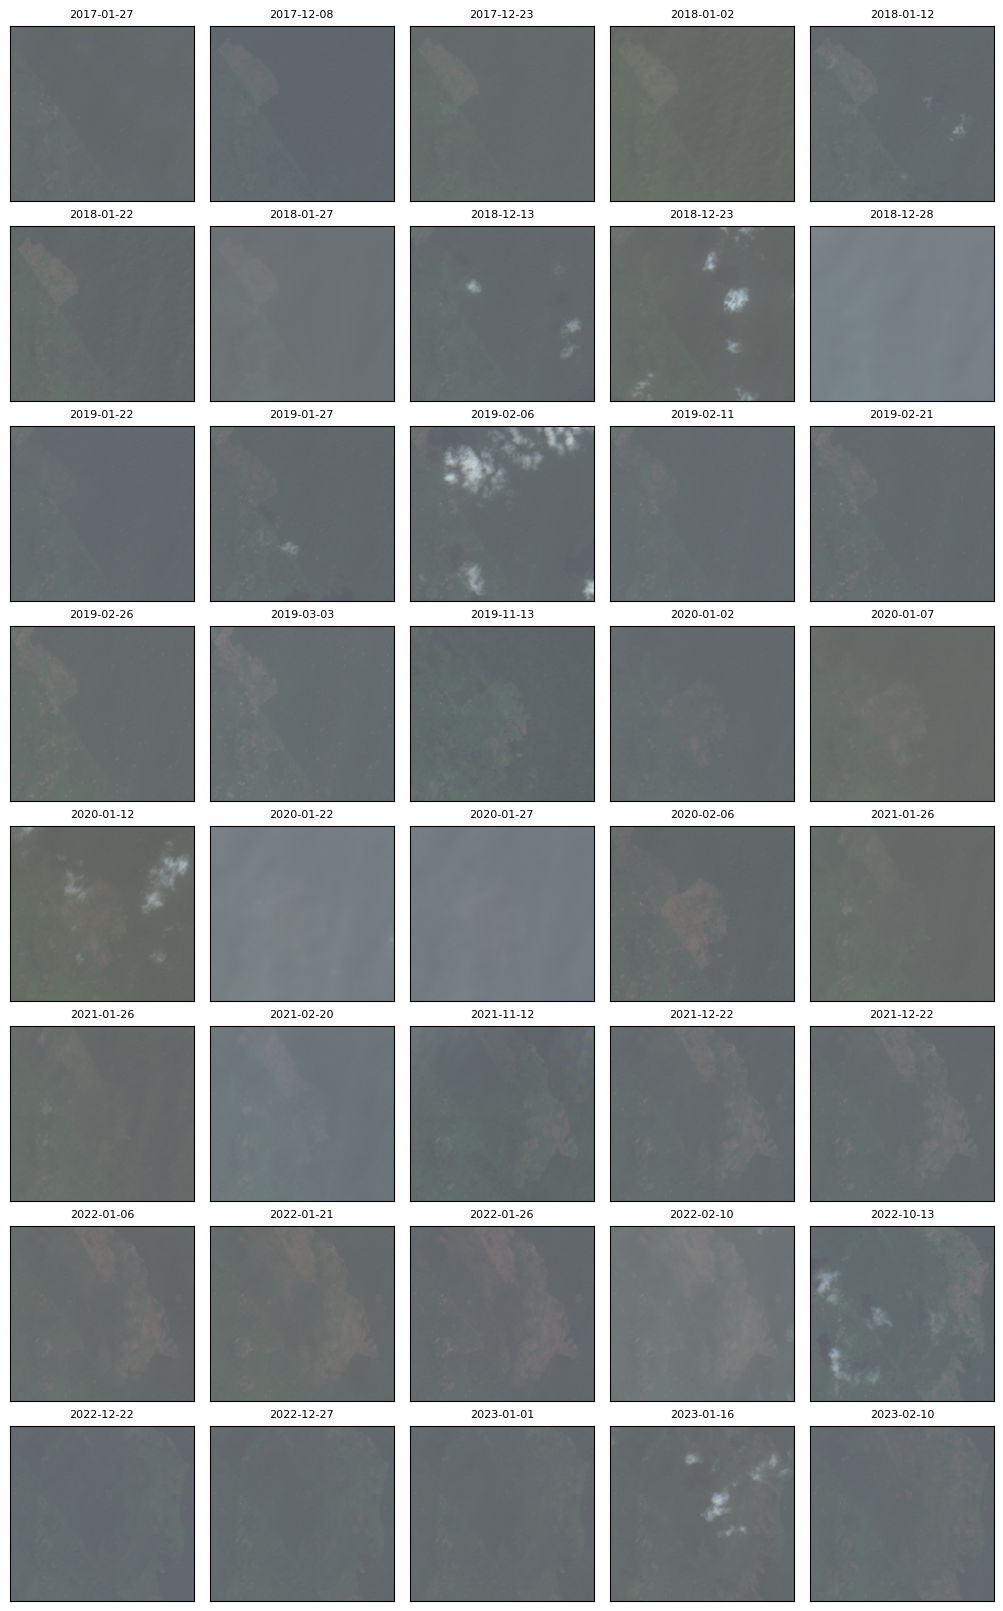

In [84]:
plt.close('all')

skip = 1
# ts = range(0, T, skip)
# t_strs_ = t_strs[::skip]
ts = np.where(non_cloudy_mask)[0]
t_strs_ = t_strs[ts]

ncols = 5
nrows = int(math.ceil(len(ts) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(ts, t_strs_, axs.flat), total=len(ts)) as bar:
    for i, (t, t_str_t, ax) in enumerate(bar):
        chip_t = raster_source.get_chip(window, bands=[3, 2, 1], time=t)
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)

if i < len(axs.flat) - 1:
    for ax in axs.flat[i + 1:]:
        ax.axis('off')
plt.show()

---

## Generate embeddings

### Get model

https://github.com/zhu-xlab/SSL4EO-S12

MoCo	ResNet18	S2-L1C 13 bands

In [85]:
from torch import nn
from torchvision.models import resnet18
from rastervision.pytorch_learner.utils import adjust_conv_channels

In [87]:
sd = torch.load('./B13_rn18_moco_0099_ckpt.pth')
sd_encoder_q = {k: v for k, v in sd['state_dict'].items() if (k.startswith('module.encoder_q') and not '.fc.' in k)}
sd_encoder_q_no_prefix = {k.replace('module.encoder_q.', ''): v for k, v in sd_encoder_q.items()}

In [88]:
model = resnet18(weights=None)
model.fc = nn.Identity()
model.conv1 = adjust_conv_channels(model.conv1, 13, pretrained=False)
model.load_state_dict(sd_encoder_q_no_prefix)
model = model.to(device=DEVICE)
model = model.eval()

---

### Run inference

In [89]:
def get_embedding(model: nn.Module, x: np.ndarray) -> np.ndarray:
    x = torch.from_numpy(x).float()
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE)
    out = model(x)
    out = out.cpu().numpy()
    return out

In [90]:
embeddings_train = []
embeddings_test = []

with tqdm(zip(ts, t_strs_), total=len(ts)) as bar, torch.inference_mode():
    for t, t_str in bar:
        chip_t = raster_source.get_chip(window, time=t)
        embedding_t = get_embedding(model, chip_t).squeeze()
        year, _, _ = t_str.split('-')
        year = int(year)
        if year < 2022:
            embeddings_train.append(embedding_t)
        else:
            embeddings_test.append(embedding_t)

embeddings_train = np.stack(embeddings_train)
embeddings_test = np.stack(embeddings_test)

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [89]:
embeddings_train.shape, embeddings_test.shape

((44, 512), (11, 512))

In [91]:
embeddings_json = dict(embeddings_train=embeddings_train, embeddings_test=embeddings_test)
json_to_file(ensure_json_serializable(embeddings_json), 'floding_embeddings.json')

---

## Analysis

In [164]:
embeddings_json = file_to_json('floding_embeddings.json')
embeddings_train = np.array(embeddings_json['embeddings_train'])
embeddings_test = np.array(embeddings_json['embeddings_test'])

In [96]:
mu = embeddings_train.mean(axis=0)
sigma = embeddings_train.std(axis=0)

In [153]:
z_train = np.nan_to_num((embeddings_train - mu) / sigma)
z_test = np.nan_to_num((embeddings_test - mu) / sigma)
z_train = np.clip(z_train, -6, 6)
z_test = np.clip(z_test, -6, 6)

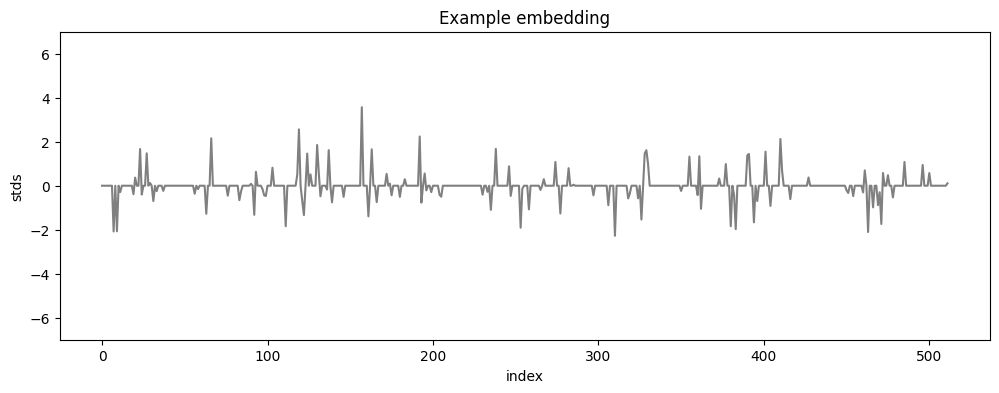

In [207]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=1)
    break
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Example embedding')
plt.show()

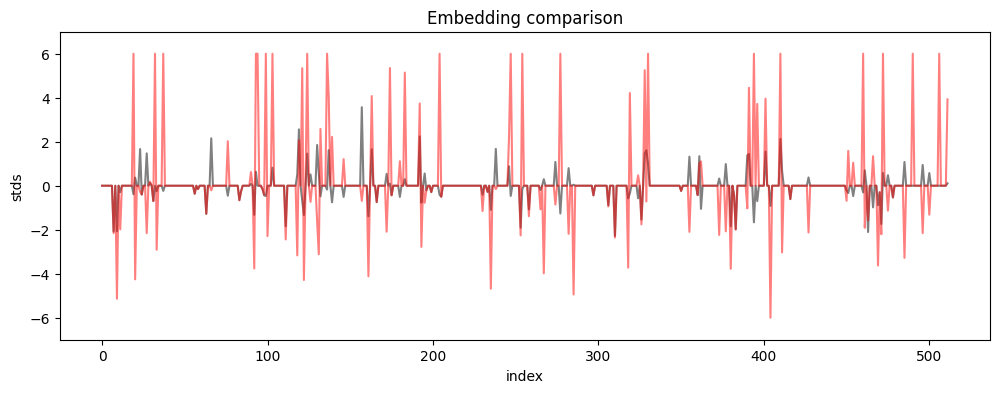

In [208]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=1)
    break
for e in z_test:
    ax.plot(e, c='r', alpha=.5)
    break
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Embedding comparison')
plt.show()

---

### Anomaly detection

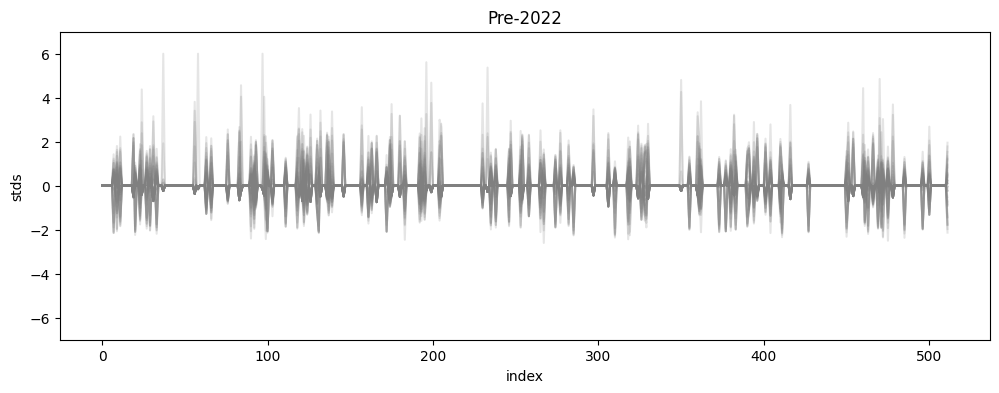

In [209]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=0.2)
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Pre-2022')
plt.show()

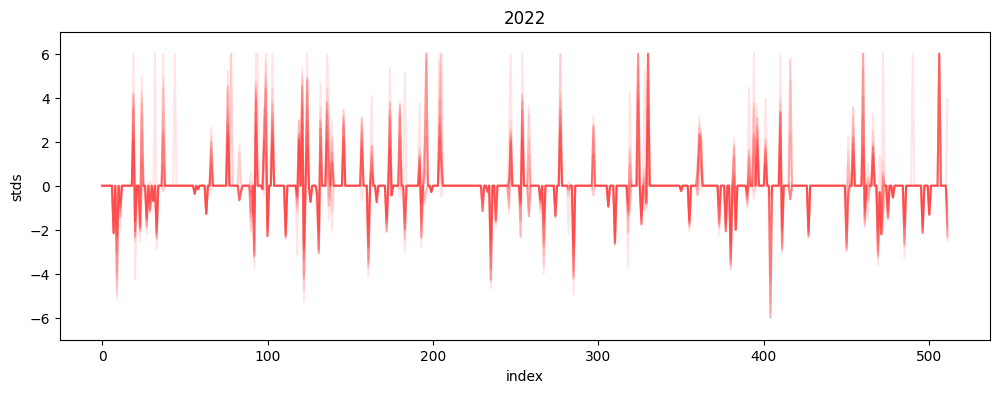

In [210]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_test:
    ax.plot(e, c='r', alpha=0.1)
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('2022')
plt.show()

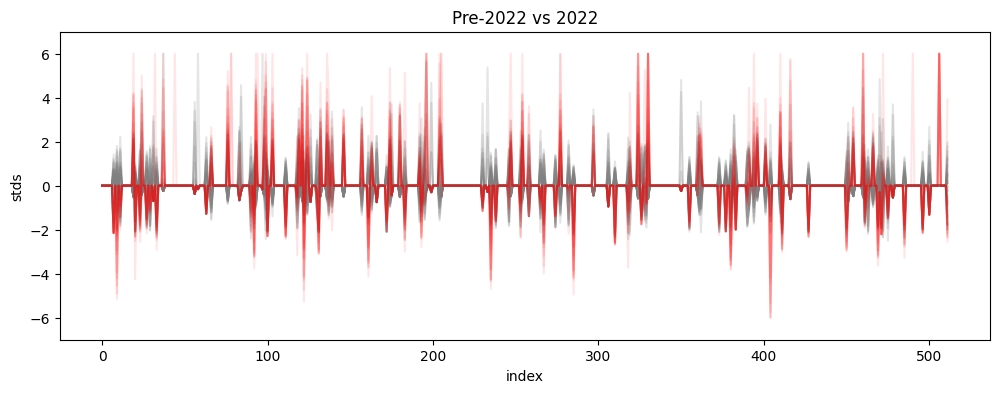

In [211]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 4), squeeze=True)
for e in z_train:
    ax.plot(e, c='gray', alpha=0.2)
for e in z_test:
    ax.plot(e, c='r', alpha=0.1)
ax.set_ylim((-7, 7))
ax.set_xlabel('index')
ax.set_ylabel('z')
ax.set_title('Pre-2022 vs 2022')
plt.show()

### Clustering

In [160]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne.fit(np.concatenate([embeddings_train, embeddings_test]))

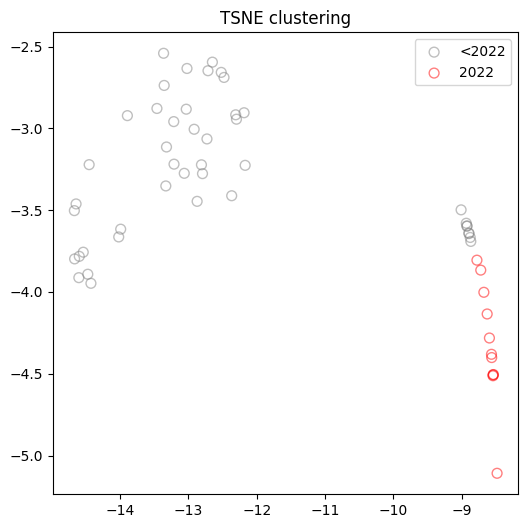

In [212]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

tsne_emb_train = tsne.embedding_[:len(embeddings_train)]
ax.scatter(tsne_emb_train[:, 0], tsne_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.5, label='<2022')

tsne_emb_test = tsne.embedding_[len(embeddings_train):]
ax.scatter(tsne_emb_test[:, 0], tsne_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.5, label='2022')

ax.legend()
ax.set_title('TSNE clustering')

plt.show()

In [177]:
inds_2020 = np.array([i for i, t_str in enumerate(t_strs) if t_str.startswith('2020-')])

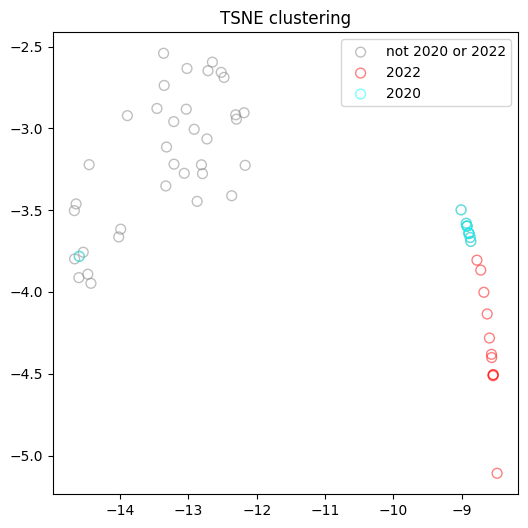

In [213]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

tsne_emb_train = tsne.embedding_[:len(embeddings_train)]
ax.scatter(tsne_emb_train[:, 0], tsne_emb_train[:, 1], s=50, ec='gray', fc='none', alpha=0.5, label='not 2020 or 2022')

tsne_emb_test = tsne.embedding_[len(embeddings_train):]
ax.scatter(tsne_emb_test[:, 0], tsne_emb_test[:, 1], s=50, ec='red', fc='none', alpha=0.5, label='2022')

tsne_emb_2020 = tsne.embedding_[inds_2020]
ax.scatter(tsne_emb_2020[:, 0], tsne_emb_2020[:, 1], s=50, ec='cyan', fc='none', alpha=0.5, label='2020')

ax.legend()
ax.set_title('TSNE clustering')

plt.show()

---

### Statistical model

In [307]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gmm = GaussianMixture(n_components=1, covariance_type='diag')
gmm.fit(embeddings_train)

GaussianMixture(covariance_type='diag')

In [308]:
gmm.score(embeddings_train) / 512

4.892162152935355

In [309]:
gmm.score(embeddings_test) / 512

2.875065765801678

In [281]:
ll = gmm.score_samples(z_test) / 512
ll

array([-140621.83679611,  -35152.55095949,  -35152.55411059,
        -35152.64417747,  -35152.59007704,  -35152.59175483,
        -35152.51082838,  -35152.46155895,  -35152.38250698,
        -35152.28248371,  -70308.57672132])

In [260]:
z_test.mean()

0.028597533244140595

In [261]:
z_train.mean()

-5.6699541471570564e-05